In [1]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import numpy as np
import seaborn as sns
import numpy as np
import pandas as pd
plt.rcParams["savefig.dpi"] = 300
plt.rcParams["savefig.bbox"] = 'tight'
import warnings
warnings.simplefilter('ignore', (FutureWarning, DeprecationWarning))
sns.set_theme(context="notebook", font_scale=1.4,
              rc={"figure.figsize": [10, 6]})

In [2]:
def plot_2d_classification(classifier, X, fill=False, ax=None, eps=None, alpha=1):                                       
    # multiclass                                                                                                                 
    if eps is None:                                                                                                              
        eps = X.std() / 2.                                                                                                       

    if ax is None:                                                                                                               
        ax = plt.gca()                                                                                                           

    x_min, x_max = X[:, 0].min() - eps, X[:, 0].max() + eps                                                                      
    y_min, y_max = X[:, 1].min() - eps, X[:, 1].max() + eps                                                                      
    xx = np.linspace(x_min, x_max, 100)                                                                                         
    yy = np.linspace(y_min, y_max, 100)                                                                                         

    X1, X2 = np.meshgrid(xx, yy)                                                                                                 
    X_grid = np.c_[X1.ravel(), X2.ravel()]                                                                                       
    decision_values = classifier.predict(X_grid)                                                                                 
    ax.imshow(decision_values.reshape(X1.shape), extent=(x_min, x_max,                                                           
                                                       y_min, y_max),                                                          
            aspect='auto', origin='lower', alpha=alpha, cmap='coolwarm')                                                               
    ax.set_xlim(x_min, x_max)                                                                                                    
    ax.set_ylim(y_min, y_max)                                                                                                    
    ax.set_xticks(())                                                                                                            
    ax.set_yticks(())  

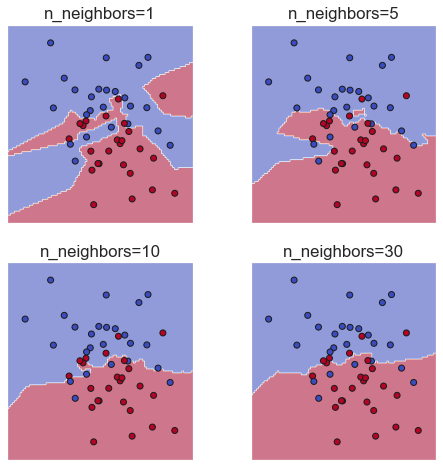

In [6]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import make_blobs

X, y = make_blobs(centers=2, cluster_std=2, random_state=0, n_samples=50)
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
for ax, n_neighbors in zip(axes.ravel(), [1, 5, 10, 30]):
    ax.set_title(f"n_neighbors={n_neighbors}")
    clf = KNeighborsClassifier(n_neighbors=n_neighbors).fit(X, y)
    ax.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k', cmap='coolwarm')
    plot_2d_classification(clf, X, ax=ax, alpha=.5)
    ax.set_aspect("equal")
# fig.savefig("images/knn_boundary_n_neighbors.png", bbox_inches='tight')

In [7]:
from sklearn.model_selection import train_test_split

neighbors = range(1, 30, 2)

training_scores = []
test_scores = []
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=13)

for n_neighbors in neighbors:
    knn = KNeighborsClassifier(n_neighbors=n_neighbors).fit(X_train, y_train)
    training_scores.append(knn.score(X_train, y_train))
    test_scores.append(knn.score(X_test, y_test))

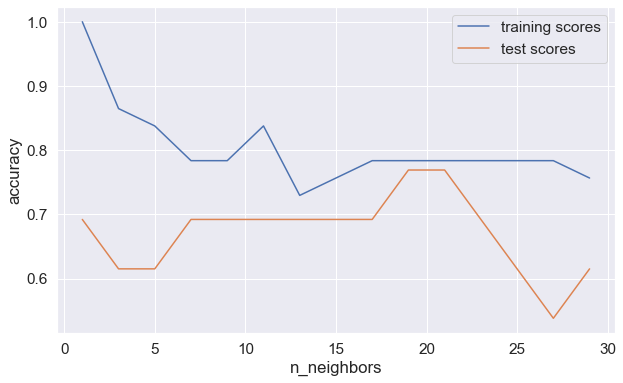

In [8]:
plt.figure()
plt.plot(neighbors, training_scores, label="training scores")
plt.plot(neighbors, test_scores, label="test scores")
plt.ylabel("accuracy")
plt.xlabel("n_neighbors")
plt.legend()
# plt.savefig("images/knn_model_complexity.png", bbox_inches='tight')

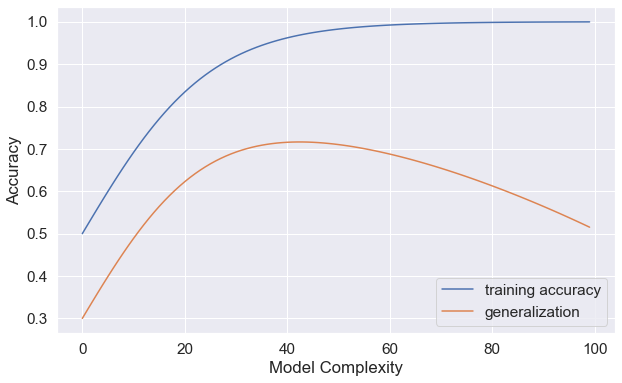

In [9]:
line = np.linspace(0, 8, 100)
train = 1./(1 + np.exp(-line))
plt.plot(train, label='training accuracy')
gen_true = - (line/ 10) ** 2 + (line/10 - .5) ** 3 + 1
gen_true = train - (line/15) ** 2 - .2
plt.plot(gen_true, label="generalization")
plt.ylabel("Accuracy")
plt.xlabel("Model Complexity")
plt.legend()
# plt.savefig("images/overfitting_validation_set_1.svg")

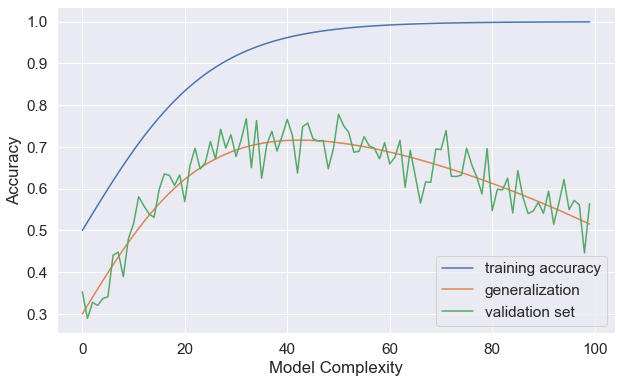

In [15]:
rng = np.random.RandomState(24)
plt.plot(train, label='training accuracy')
plt.plot(gen_true, label="generalization")
validation_set = gen_true + rng.normal(scale=.04, size=100)
plt.plot(validation_set, label="validation set")
plt.ylabel("Accuracy")
plt.xlabel("Model Complexity")
plt.legend()
# plt.savefig("images/overfitting_validation_set_2.svg")

In [19]:
import pandas as pd
from sklearn import datasets
import matplotlib.pyplot as plt
from scipy.stats import randint
import numpy as np

from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.ensemble import RandomForestClassifier

In [20]:
rng = np.random.RandomState(0)

X, y = datasets.make_classification(n_samples=700, random_state=rng)

clf = RandomForestClassifier(n_estimators=20, random_state=rng)

param_dist = {
    "max_depth": [3, None],
    "max_features": randint(1, 11),
    "min_samples_split": randint(2, 11),
    "bootstrap": [True, False],
    "criterion": ["gini", "entropy"],
}

rsh = HalvingRandomSearchCV(
    estimator=clf, param_distributions=param_dist, factor=2, random_state=rng,
    n_jobs=8
)
rsh.fit(X, y)

HalvingRandomSearchCV(estimator=RandomForestClassifier(n_estimators=20,
                                                       random_state=RandomState(MT19937) at 0x149AAB040),
                      factor=2, n_jobs=8,
                      param_distributions={'bootstrap': [True, False],
                                           'criterion': ['gini', 'entropy'],
                                           'max_depth': [3, None],
                                           'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x14946c880>,
                                           'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x149333430>},
                      random_state=RandomState(MT19937) at 0x149AAB040)

In [47]:
mean_scores.iloc[:, mean_scores.loc[5].argmax()]

iter
0    0.800000
1    0.900000
2    0.912500
3    0.931250
4    0.943750
5    0.957812
Name: {'bootstrap': False, 'criterion': 'gini', 'max_depth': None, 'max_features': 6, 'min_samples_split': 2}, dtype: float64

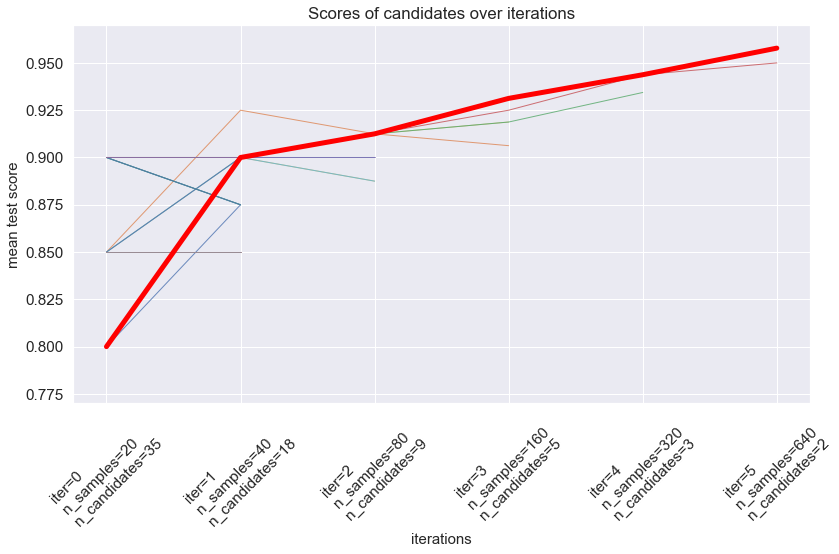

In [59]:
results = pd.DataFrame(rsh.cv_results_)
results["params_str"] = results.params.apply(str)
results.drop_duplicates(subset=("params_str", "iter"), inplace=True)
mean_scores = results.pivot(
    index="iter", columns="params_str", values="mean_test_score"
)
fig, ax = plt.subplots(figsize=(12, 8))
mean_scores.plot(legend=False, alpha=0.8, lw=1, ax=ax)
mean_scores.iloc[:, mean_scores.loc[5].argmax()].plot(legend=False, alpha=1, lw=5, ax=ax, color="red")

labels = [
    f"iter={i}\nn_samples={rsh.n_resources_[i]}\nn_candidates={rsh.n_candidates_[i]}"
    for i in range(rsh.n_iterations_)
]

ax.set_xticks(range(rsh.n_iterations_))
ax.set_xticklabels(labels, rotation=45, multialignment="left")
ax.set_title("Scores of candidates over iterations")
ax.set_ylim((0.77, 0.97))
ax.set_ylabel("mean test score", fontsize=15)
ax.set_xlabel("iterations", fontsize=15)
plt.tight_layout()
# plt.show()
plt.savefig("images/halvingcv.svg")

In [16]:
from sklearn.datasets import load_iris
from sklearn.utils import shuffle
iris = load_iris()

X, y = iris.data, iris.target
X, y = shuffle(X, y)

In [17]:
# some values missing only
rng = np.random.RandomState(0)
X_some_missing = X.copy()
mask = np.abs(X[:, 2] - rng.normal(loc=5.5, scale=.7, size=X.shape[0])) < .6
X_some_missing[mask, 3] = np.NaN
# different random numbers
mask2 = np.abs(X[:, 2] - rng.normal(loc=5.5, scale=.7, size=X.shape[0])) < .6
X_some_missing[mask2, 2] = np.NaN
X_some_missing[:30]

array([[4.8, 3.4, 1.9, 0.2],
       [6.3, 2.8, 5.1, 1.5],
       [6.7, 2.5, 5.8, nan],
       [4.9, 2.5, nan, 1.7],
       [6.4, 3.2, 4.5, 1.5],
       [7.7, 3.8, 6.7, 2.2],
       [4.9, 3.6, 1.4, 0.1],
       [5.5, 3.5, 1.3, 0.2],
       [5.9, 3. , nan, nan],
       [5.8, 2.7, 3.9, 1.2],
       [5.8, 2.7, nan, nan],
       [4.6, 3.4, 1.4, 0.3],
       [6.1, 2.8, 4. , 1.3],
       [6.5, 3. , nan, nan],
       [5.6, 3. , nan, 1.5],
       [5.6, 2.9, 3.6, 1.3],
       [5.8, 2.8, nan, 2.4],
       [5.8, 2.7, 5.1, nan],
       [4.3, 3. , 1.1, 0.1],
       [5.5, 2.5, 4. , 1.3],
       [6.7, 3.3, nan, 2.1],
       [7.1, 3. , nan, nan],
       [6.7, 3. , 5. , 1.7],
       [5.4, 3.7, 1.5, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [6.2, 2.9, 4.3, nan],
       [5.7, 2.5, nan, nan],
       [6.7, 3.1, nan, 1.5],
       [6.1, 3. , nan, 1.4],
       [6.4, 2.8, nan, 2.2]])

In [18]:
# from now on use X_ = X_some_missing
X_ = X_some_missing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
X_train, X_test, y_train, y_test = train_test_split(X_, y, stratify=y, random_state=0)

In [ ]:
X_df = pd.DataFrame(X_, columns=iris.feature_names)

In [ ]:
X_df['target'] = y

In [ ]:
X_df

In [ ]:
X_df.to_csv("data/iris_w_missing.csv", index=False)

In [ ]:
from sklearn.impute import SimpleImputer
imp = SimpleImputer(strategy="median").fit(X_train)
X_median_imp = imp.transform(X_train)
X_median_imp[-30:]

In [ ]:
import matplotlib.patches as patches
imputed_mask = np.any(np.isnan(X_train), axis=1)

def plot_imputation(X_imp, title=None, ax=None):
    if ax is None:
        ax = plt.gca()
    if title is not None:
        ax.set_title(title)
    ax.scatter(X_imp[imputed_mask, 2], X_imp[imputed_mask, 3], c=plt.cm.tab10(y_train[imputed_mask]), alpha=.6, marker="s")
    ax.scatter(X_imp[~imputed_mask, 2], X_imp[~imputed_mask, 3], c=plt.cm.tab10(y_train[~imputed_mask]), alpha=.6)
    
    square = plt.Line2D((0,), (0,), linestyle='', marker="s", markerfacecolor="w", markeredgecolor="k", label='Imputed data')
    circle = plt.Line2D((0,), (0,), linestyle='', marker="o", markerfacecolor="w", markeredgecolor="k", label='Real data')
    ax.set_xlabel(iris.feature_names[2])
    ax.set_ylabel(iris.feature_names[3])

    plt.legend(handles=[square, circle], numpoints=1, loc="best")

In [ ]:
from sklearn.impute import KNNImputer

knnimp = KNNImputer().fit(X_train)
X_train_knn = knnimp.transform(X_train)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

rfimp = IterativeImputer(estimator=RandomForestRegressor())
rfimp.fit(X_train)
X_rf_imp = rfimp.transform(X_train)



In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(16, 6), constrained_layout=True)
plot_imputation(X_median_imp, "Median", ax=axes[0])
plot_imputation(X_train_knn, "KNN", ax=axes[1])
plot_imputation(X_rf_imp, "Random Forest imputation", ax=axes[2])
plt.savefig("images/med_knn_rf_comparison.png")

In [ ]:
import pandas as pd

In [ ]:
approval = pd.read_csv("data/approval_topline.csv", parse_dates=['timestamp'], index_col='timestamp')

In [ ]:
approval_est = approval.loc[approval['subgroup'] == "Adults", ["approve_estimate"]]

In [ ]:
approval_est.to_csv("data/approval_processed.csv")

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
approval_est.plot(ax=ax)
ax.set_title("Approval Ratings")
fig.savefig("images/approval_ratings.png")

In [ ]:
from matplotlib.patches import Rectangle
rng = np.random.RandomState(42)
fig, ax = plt.subplots(figsize=(10, 6))
approval_est.plot(ax=ax)
xlim, ylim = ax.get_xlim(), ax.get_ylim()

for i in range(20):
    rect = Rectangle((rng.randint(xlim[0], xlim[1]), ylim[0]), 10,
                     ylim[1]-ylim[0], facecolor='#FFAAAA', alpha=0.8)
    ax.add_artist(rect)
    
# plt.title("Presidential approval estimates by fivethirtyeight")
plt.legend([rect], ['Random Test Set'] )
ax.set_xlabel("")
ax.set_title("Approval Ratings")
fig.savefig("images/approval_ratings_random.png")

In [ ]:
from matplotlib.patches import Rectangle

rng = np.random.RandomState(42)
approval_est.plot()

ax = plt.gca()
xlim, ylim = ax.get_xlim(), ax.get_ylim()
rect = Rectangle((xlim[1] - 300, ylim[0]), 300, ylim[1]-ylim[0], facecolor='#FFAAAA', alpha=0.8)
ax.add_artist(rect)

plt.title("Approvael Ratings")
plt.legend([rect], ['Structured Test Set'] )
ax.set_xlabel("")
plt.savefig("images/approval_ratings_structured.png")